# Atmospheric composition distribution by CAMS and IASI

### Main goal:
* Compare IASI and CAMS datasets for CO and O<sub>3</sub> (Level 3).

## Imports and supporting functions

In [1]:
import os 
from sentinelsat.sentinel import SentinelAPI, geojson_to_wkt
import cdsapi
import cfgrib
import xarray as xr
import pandas as pd
import numpy as np
from itertools import product
import scipy.interpolate
from copy import copy
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import math
import geojson
from sklearn.linear_model import LinearRegression
from scipy.spatial.distance import cdist
import datetime as dt
import geocoder
import seaborn as sns
from matplotlib.cbook import boxplot_stats  

In [2]:
%run functions/functions_general.ipynb
%run functions/functions_cams.ipynb
%run functions/functions_iasi.ipynb

In [3]:
# Hide pandas warning
pd.options.mode.chained_assignment = None

## 1. Define datasets

In [4]:
# Define component
component_nom = 'CO'

# Define sensor
sensor = 'iasi'
sensor_type = 'L3'

# Define model
model = 'cams'
model_full_name = 'cams-global-reanalysis-eac4-monthly'

# Check if comparison is possible
comparison_check(sensor, model, component_nom, model_full_name, sensor_type)

# Get component full name and molecular weight
component, component_mol_weight, product_type, sensor_column = components_table(sensor, component_nom)

# Folders generation
generate_folders(model, sensor, component_nom)

The comparison is possible and will start now.


In [5]:
# Define extent
lon_min = 0
lon_max = 20
lat_min = 40
lat_max = 50
"""
lon_min = -25
lon_max = 45
lat_min = 30
lat_max = 70
"""
# Create bbox
bbox = ((lon_min, lat_min), (lon_max, lat_max))

# Define search period
start_date = '2020-01-01'
end_date = '2020-12-31'
dates = search_period(start_date, end_date, sensor, sensor_type)

SEARCH PERIOD
- In months: ('2020-01', '2020-02', '2020-03', '2020-04', '2020-05', '2020-06', '2020-07', '2020-08', '2020-09', '2020-10', '2020-11', '2020-12')


## 2. Model data

### Download and read data as xarray

In [6]:
model_product_name, model_type = CAMS_download(dates, start_date, end_date, component, component_nom, 
                                               model_full_name, model_level = 'Single')

The file exists, it will not be downloaded again.


In [7]:
model_ds, dates = CAMS_read(model_product_name, component, component_nom, dates)
model_ds

<xarray.Dataset>
Dimensions:     (latitude: 241, longitude: 480, time: 12)
Coordinates:
    number      int64 ...
  * time        (time) datetime64[ns] 2020-01-01 2020-02-01 ... 2020-12-01
    step        timedelta64[ns] ...
    surface     float64 ...
  * latitude    (latitude) float64 -90.0 -89.25 -88.5 -87.75 ... 88.5 89.25 90.0
  * longitude   (longitude) float64 -180.0 -179.2 -178.5 ... 177.8 178.5 179.2
    valid_time  (time) datetime64[ns] ...
Data variables:
    component   (time, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2021-09-19T18:02 GRIB to CDM+CF via cfgrib-0.9.9...

### Convert CAMS data units (kg/m2 to molecules/cm<sup>2</sup>)

In [8]:
model_ds, units = model_convert_units(model_ds, model, component_mol_weight, component, conversion_method = 'Simple')

The model component units have been converted from kg m**-2 to molec cm-2.


## 3. Sensor data

### Download and read data as xarray

In [9]:
sensor_product_names = sensor_download(sensor, sensor_type, component_nom, dates)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1030k  100 1030k    0     0  5255k      0 --:--:-- --:--:-- --:--:-- 5255k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1030k  100 1030k    0     0  6777k      0 --:--:-- --:--:-- --:--:-- 6777k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1030k  100 1030k    0     0  6168k      0 --:--:-- --:--:-- --:--:-- 6205k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1030k  100 1030k    0     0  6960k      0 --:--:-- --:--:-- --:--:-- 6960k
  % Total    % Received % Xferd  Average Speed   Tim

In [10]:
sensor_ds, _, _ = sensor_read(sensor, sensor_type, component_nom, sensor_product_names)
sensor_ds

<xarray.Dataset>
Dimensions:         (latitude: 180, longitude: 360, time: 12)
Coordinates:
  * time            (time) datetime64[ns] 2020-01-01 2020-02-01 ... 2020-12-01
  * latitude        (latitude) float32 -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
  * longitude       (longitude) float32 -179.5 -178.5 -177.5 ... 178.5 179.5
Data variables:
    COgridDAY       (time, longitude, latitude) float32 0.01368 0.01131 ... nan
    COgridNIGHT     (time, longitude, latitude) float32 nan nan ... 0.0326
    ErrorgridDAY    (time, longitude, latitude) float32 0.0006013 ... nan
    ErrorgridNIGHT  (time, longitude, latitude) float32 nan nan ... 0.002241
Attributes: (12/32)
    title:                                   Monthly IASI/Metop-C ULB-LATMOS ...
    institution:                             LATMOS
    product_version:                         6.5.0
    history:                                 2020-11-18 22:22:53 - Product ge...
    summary:                                 This dataset contains Level 3 ca...
    source:                                  EUMETSAT IASI Level 2 carbon mon...
    ...                                      ...
    sensor:                                  IASI
    spatial_resolution:                      grid: 1 deg x 1 deg
    creator_type:                            institution
    creator_name:                            LATMOS
    contact_email:                           contact form at http://iasi.aeri...
    data_policy:                             see https://iasi.aeris-data.fr/d...

### Convert IASI data units (From mol/m<sup>2</sup> to molecules/cm<sup>2</sup>)

In [11]:
sensor_ds = sensor_convert_units(sensor_ds, sensor_column, sensor, component)
sensor_ds

The sensor component units have been converted from mol cm-2 to molec cm-2.


<xarray.Dataset>
Dimensions:         (latitude: 180, longitude: 360, time: 12)
Coordinates:
  * time            (time) datetime64[ns] 2020-01-01 2020-02-01 ... 2020-12-01
  * latitude        (latitude) float32 -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
  * longitude       (longitude) float32 -179.5 -178.5 -177.5 ... 178.5 179.5
Data variables:
    COgridDAY       (time, longitude, latitude) float64 8.241e+17 ... nan
    COgridNIGHT     (time, longitude, latitude) float64 nan nan ... 1.963e+18
    ErrorgridDAY    (time, longitude, latitude) float64 3.621e+16 ... nan
    ErrorgridNIGHT  (time, longitude, latitude) float64 nan nan ... 1.35e+17
Attributes: (12/32)
    title:                                   Monthly IASI/Metop-C ULB-LATMOS ...
    institution:                             LATMOS
    product_version:                         6.5.0
    history:                                 2020-11-18 22:22:53 - Product ge...
    summary:                                 This dataset contains Level 3 ca...
    source:                                  EUMETSAT IASI Level 2 carbon mon...
    ...                                      ...
    sensor:                                  IASI
    spatial_resolution:                      grid: 1 deg x 1 deg
    creator_type:                            institution
    creator_name:                            LATMOS
    contact_email:                           contact form at http://iasi.aeri...
    data_policy:                             see https://iasi.aeris-data.fr/d...

## 4. Match data

In [12]:
kernels_method = None
match_table = generate_match_table(sensor_ds, model_ds, bbox, kernels_method, 
                                   sensor, component_nom, sensor_column)
match_table

FOR MONTH: 2020-01
The dataset does not contain data to apply the averaging kernels.
The model does not contain levels data.
The columns model data will be matched to the sensor data by nearest neighbours.
FOR MONTH: 2020-02
The dataset does not contain data to apply the averaging kernels.
The model does not contain levels data.
The columns model data will be matched to the sensor data by nearest neighbours.
FOR MONTH: 2020-03
The dataset does not contain data to apply the averaging kernels.
The model does not contain levels data.
The columns model data will be matched to the sensor data by nearest neighbours.
FOR MONTH: 2020-04
The dataset does not contain data to apply the averaging kernels.
The model does not contain levels data.
The columns model data will be matched to the sensor data by nearest neighbours.
FOR MONTH: 2020-05
The dataset does not contain data to apply the averaging kernels.
The model does not contain levels data.
The columns model data will be matched to the senso

,latitude,longitude,time,COgridDAY,COgridNIGHT,ErrorgridDAY,ErrorgridNIGHT,model_column
0,39.5,-0.5,2020-01-01,1.820399e+18,1.865734e+18,8.442922e+15,1.573237e+16,1.787360e+18
1,39.5,0.5,2020-01-01,1.929432e+18,1.987607e+18,9.343190e+15,1.041016e+16,1.836948e+18
2,39.5,1.5,2020-01-01,1.964625e+18,2.034503e+18,1.004758e+16,1.035251e+16,1.801730e+18
3,39.5,2.5,2020-01-01,1.992570e+18,1.996418e+18,1.092976e+16,1.096303e+16,1.789369e+18
4,39.5,3.5,2020-01-01,1.993412e+18,2.008219e+18,1.009494e+16,1.092344e+16,1.788184e+18
...,...,...,...,...,...,...,...,...
226,49.5,15.5,2020-12-01,1.859563e+18,1.930511e+18,2.085240e+16,2.722560e+16,1.796041e+18
227,49.5,16.5,2020-12-01,1.893719e+18,1.950735e+18,2.182008e+16,2.383639e+16,1.808739e+18
228,49.5,17.5,2020-12-01,1.854305e+18,1.987805e+18,2.375060e+16,1.936416e+16,1.815093e+18
229,49.5,18.5,2020-12-01,1.771571e+18,1.910454e+18,1.832052e+16,2.335869e+16,1.739954e+18


## 5. Merge data and calculate difference

In [13]:
merge_table = generate_merge_table(match_table, sensor_ds, model_ds, kernels_method, sensor_column, sensor)
merge_table

COgridDAY   COgridNIGHT  ErrorgridDAY  \
latitude longitude time                                                   
39.5     -0.5      2020-01-01  1.820399e+18  1.865734e+18  8.442922e+15   
                   2020-02-01  1.848103e+18  1.924695e+18  8.054912e+15   
                   2020-03-01  1.961307e+18  2.117196e+18  9.267710e+15   
                   2020-04-01  2.188804e+18  2.341320e+18  6.673904e+15   
                   2020-05-01  2.033774e+18  2.066118e+18  4.652159e+15   
...                                     ...           ...           ...   
49.5      19.5     2020-08-01  1.670452e+18  1.677978e+18  4.768783e+15   
                   2020-09-01  1.772663e+18  1.742999e+18  6.595505e+15   
                   2020-10-01  1.842604e+18  1.821102e+18  1.129576e+16   
                   2020-11-01  1.639320e+18  1.652998e+18  1.373805e+16   
                   2020-12-01  1.720766e+18  1.853081e+18  1.788719e+16   

                               ErrorgridNIGHT  model_column    difference  
latitude longitude time                                                    
39.5     -0.5      2020-01-01    1.573237e+16  1.787360e+18  3.303968e+16  
                   2020-02-01    1.514729e+16  1.751189e+18  9.691440e+16  
                   2020-03-01    1.576865e+16  1.886264e+18  7.504350e+16  
                   2020-04-01    1.685665e+16  2.005378e+18  1.834259e+17  
                   2020-05-01    1.127121e+16  1.860351e+18  1.734231e+17  
...                                       ...           ...           ...  
49.5      19.5     2020-08-01    1.254793e+16  1.493013e+18  1.774384e+17  
                   2020-09-01    1.334282e+16  1.558499e+18  2.141645e+17  
                   2020-10-01    1.781552e+16  1.692913e+18  1.496907e+17  
                   2020-11-01    2.053697e+16  1.573000e+18  6.631914e+16  
                   2020-12-01    2.109616e+16  1.698683e+18  2.208233e+16  

[2772 rows x 6 columns]

In [14]:
descr_statistics_table = merge_table.describe()
descr_statistics_table

,COgridDAY,COgridNIGHT,ErrorgridDAY,ErrorgridNIGHT,model_column,difference
count,2.772000e+03,2.772000e+03,2.772000e+03,2.772000e+03,2.772000e+03,2.772000e+03
mean,1.907778e+18,1.930484e+18,8.456605e+15,1.334073e+16,1.708970e+18,1.988075e+17
std,2.123633e+17,1.873997e+17,4.502707e+15,4.600336e+15,1.816351e+17,8.827323e+16
min,1.251345e+18,1.390465e+18,2.328603e+15,6.595089e+15,1.140818e+18,-1.218633e+17
25%,1.765209e+18,1.777971e+18,5.273076e+15,9.904612e+15,1.567378e+18,1.425352e+17
50%,1.915653e+18,1.928060e+18,7.281673e+15,1.242500e+16,1.729849e+18,2.109708e+17
75%,2.047796e+18,2.061638e+18,1.000702e+16,1.545172e+16,1.828307e+18,2.597510e+17
max,2.457441e+18,2.433946e+18,3.608557e+16,3.880045e+16,2.130026e+18,4.840645e+17


## 6. Show comparison plots

### Select plot dates

In [15]:
plot_dates = plot_period(sensor_ds, sensor)

The plots will be shown for the following dates:
['2020-01' '2020-02' '2020-03' '2020-04' '2020-05' '2020-06' '2020-07'
 '2020-08' '2020-09' '2020-10' '2020-11' '2020-12']


### Select plot extent

In [16]:
plot_bbox = plot_extent(bbox)

The plots will be shown for the following spatial extent: 
((0, 40), (20, 50))


### Compare CAMS and IASI total columns

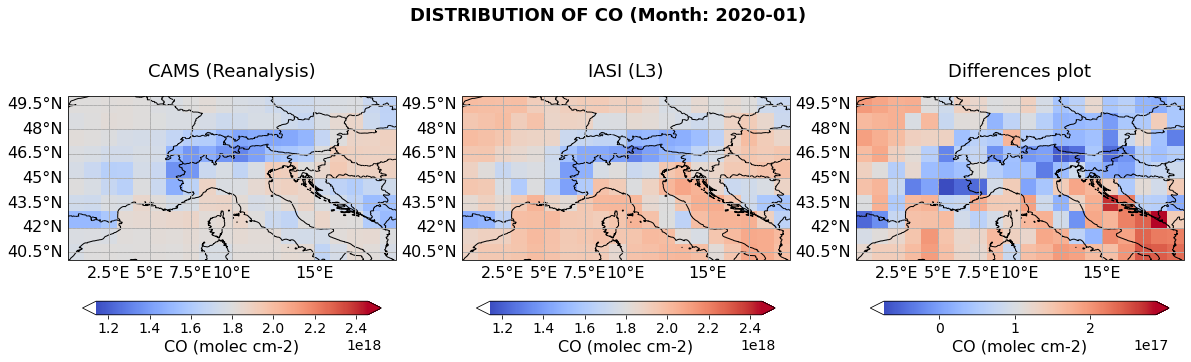

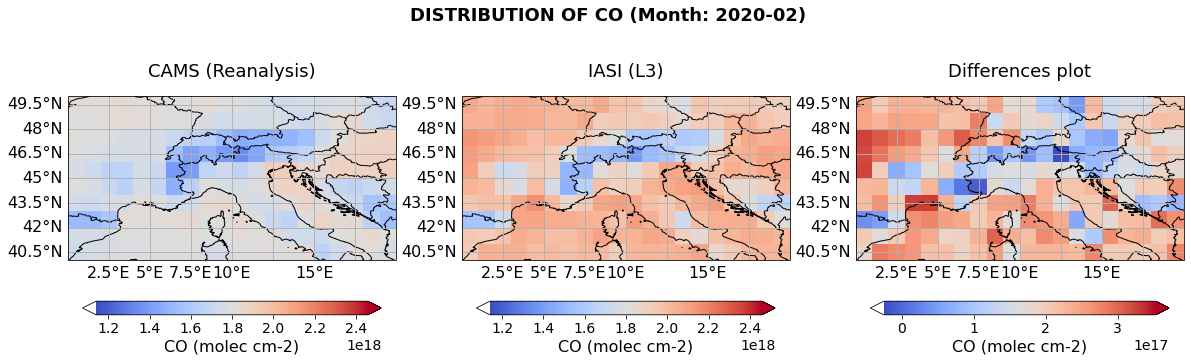

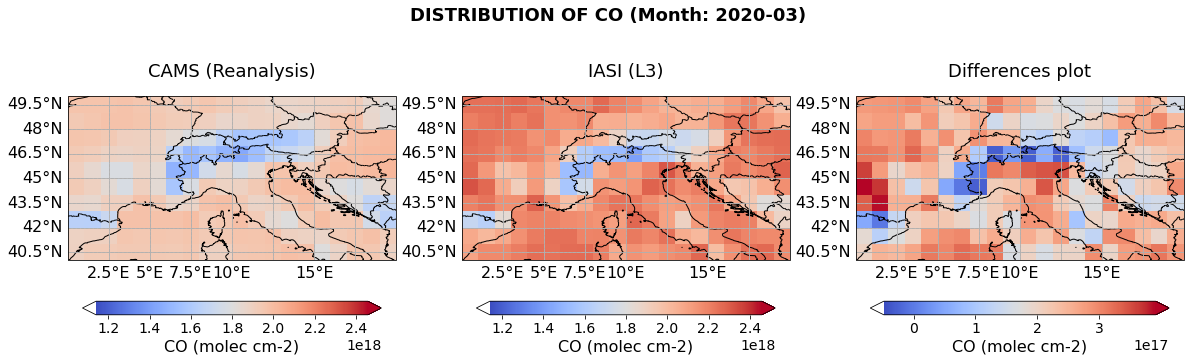

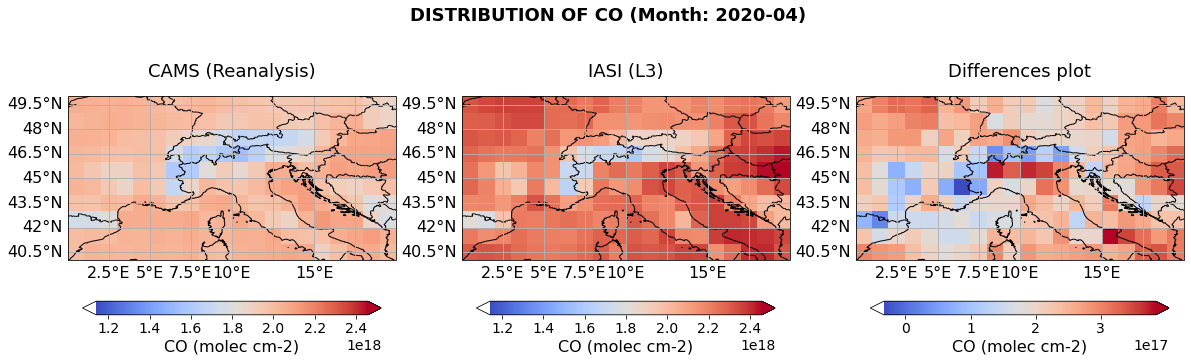

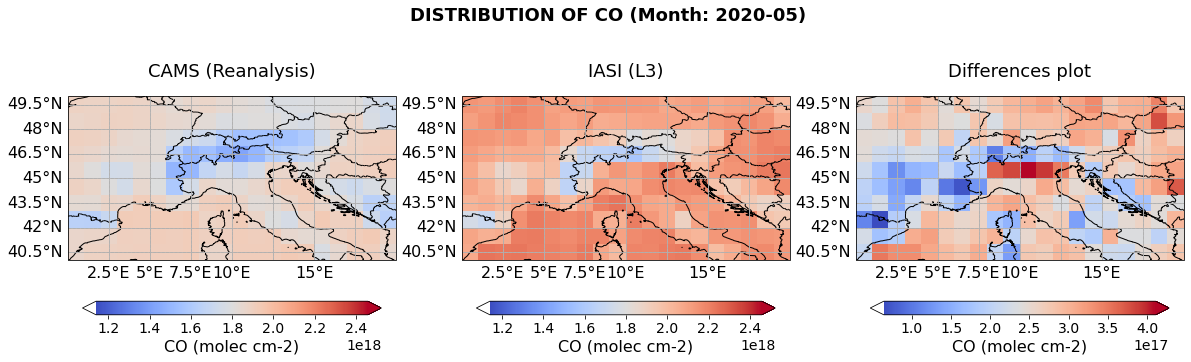

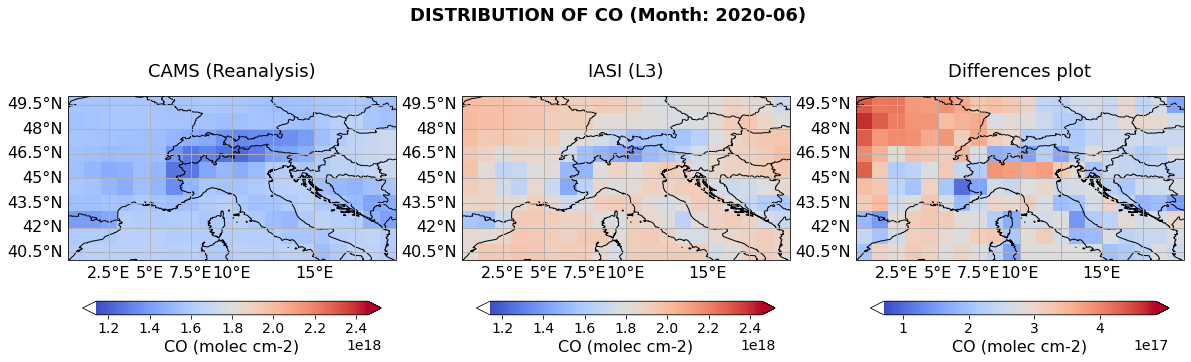

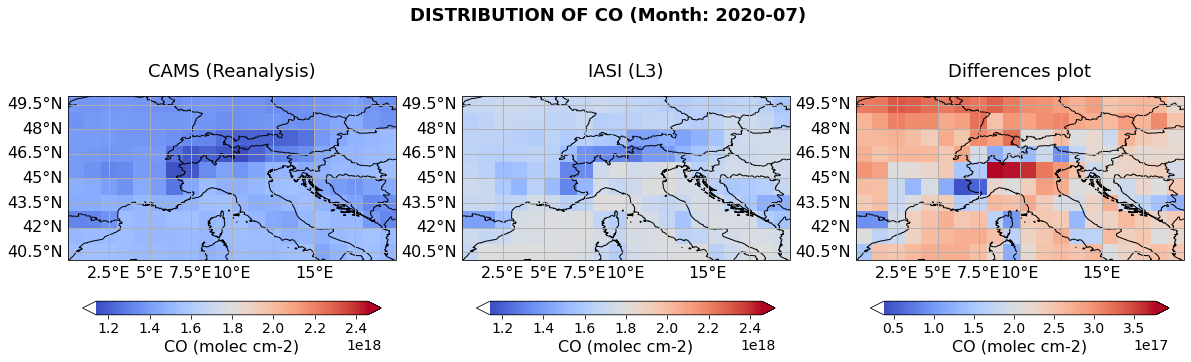

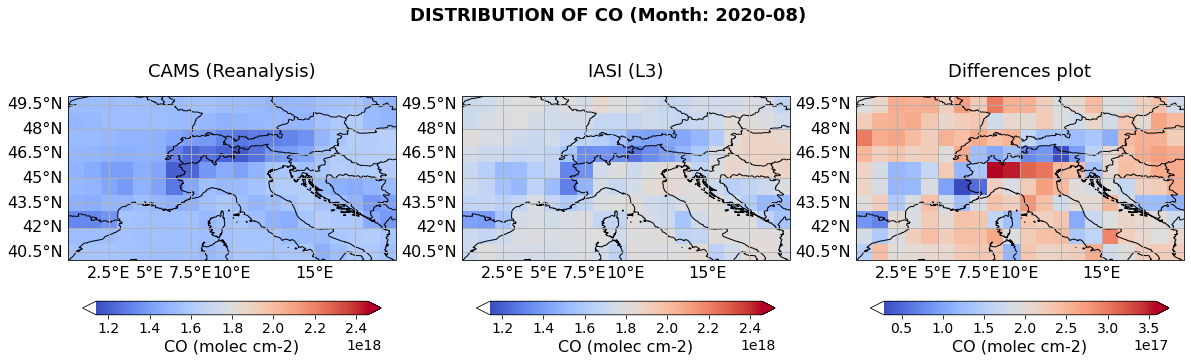

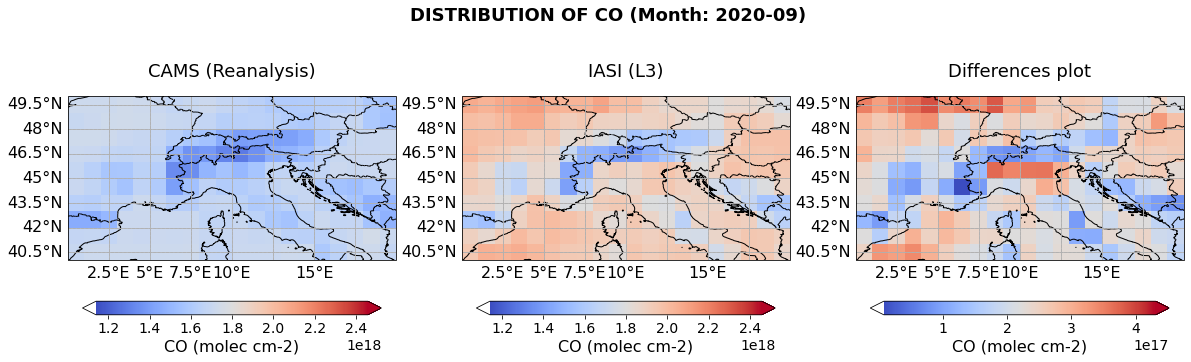

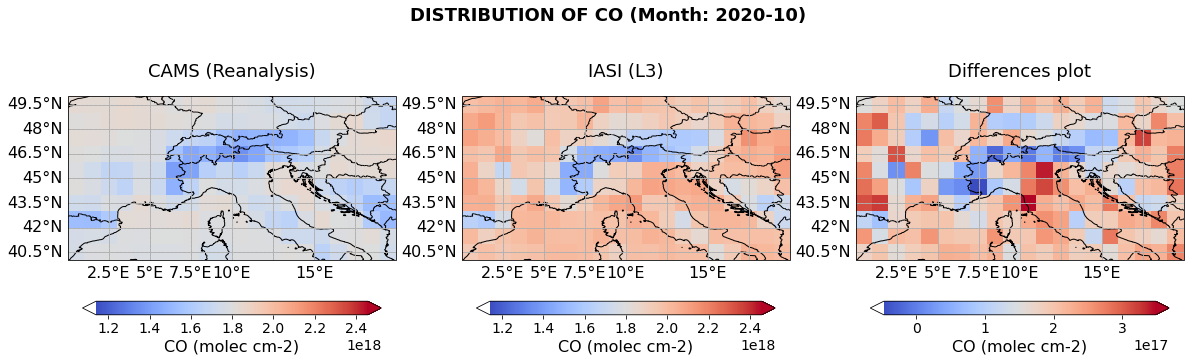

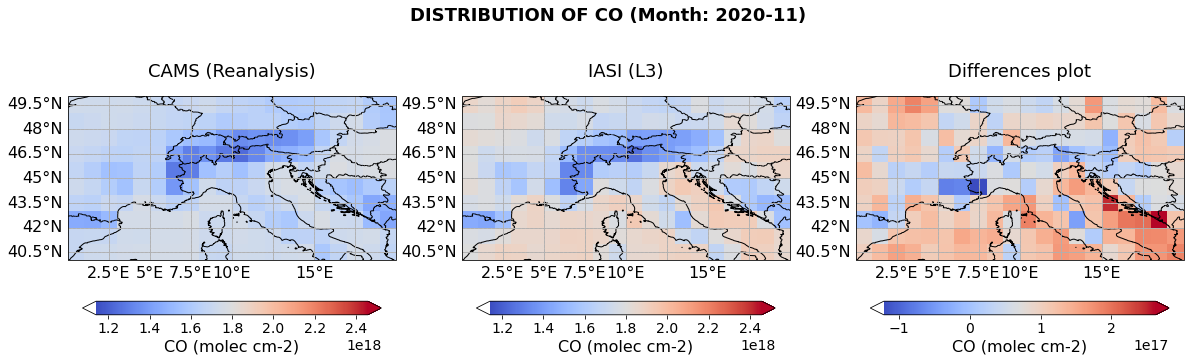

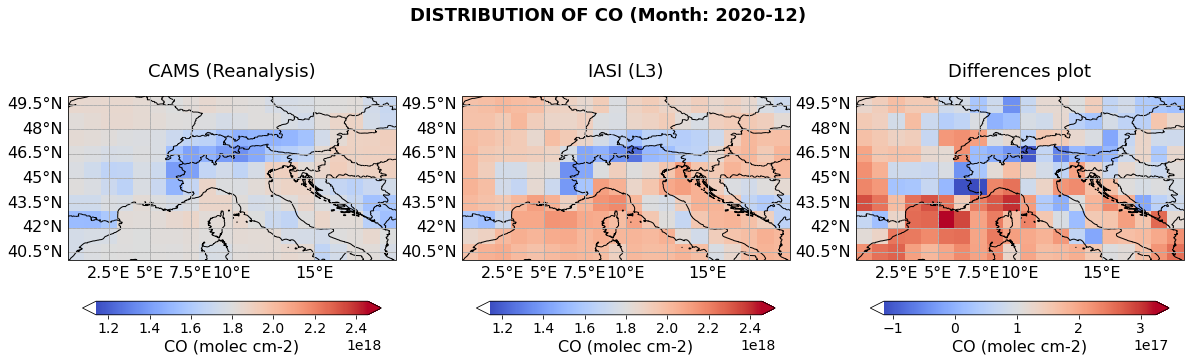

In [17]:
# Choose distribution (aggregated or individual)
distribution_type = 'individual'

# Choose range (original, equal or manual)
range_type = 'equal'
vmin_manual = None
vmax_manual = None

# Define projection and colors
projection = ccrs.PlateCarree()
color_scale =  'coolwarm'

visualize_model_vs_sensor(model, sensor, component_nom, units, merge_table, plot_dates, plot_bbox, 20, 0.98, 
                          model_type, sensor_type, range_type, sensor_column, distribution_type, projection,
                          color_scale, vmin_manual, vmax_manual)

## 7. Retrieve nearest values to specific latitude and longitude

COgridDAY  \
lat_search lon_search latitude longitude time                       
50         15         49.5     14.5      2020-01-01  1.845120e+18   
                                         2020-02-01  1.968400e+18   
                                         2020-03-01  2.059167e+18   
                                         2020-04-01  2.198212e+18   
                                         2020-05-01  2.122875e+18   
                                         2020-06-01  1.818929e+18   
                                         2020-07-01  1.646633e+18   
                                         2020-08-01  1.756966e+18   
                                         2020-09-01  1.871112e+18   
                                         2020-10-01  1.970370e+18   
                                         2020-11-01  1.783956e+18   
                                         2020-12-01  1.911827e+18   
4          10         39.5     9.5       2020-01-01  1.885543e+18   
                                         2020-02-01  1.940023e+18   
                                         2020-03-01  2.113067e+18   
                                         2020-04-01  2.263225e+18   
                                         2020-05-01  2.061682e+18   
                                         2020-06-01  1.785922e+18   
                                         2020-07-01  1.646328e+18   
                                         2020-08-01  1.681547e+18   
                                         2020-09-01  1.832937e+18   
                                         2020-10-01  1.967103e+18   
                                         2020-11-01  1.749976e+18   
                                         2020-12-01  1.924051e+18   
20         30         39.5     19.5      2020-01-01  2.068388e+18   
                                         2020-02-01  2.055812e+18   
                                         2020-03-01  2.257265e+18   
                                         2020-04-01  2.397733e+18   
                                         2020-05-01  2.212923e+18   
                                         2020-06-01  1.938047e+18   
                                         2020-07-01  1.762998e+18   
                                         2020-08-01  1.812702e+18   
                                         2020-09-01  1.913626e+18   
                                         2020-10-01  2.013191e+18   
                                         2020-11-01  1.902065e+18   
                                         2020-12-01  2.014340e+18   

                                                      COgridNIGHT  \
lat_search lon_search latitude longitude time                       
50         15         49.5     14.5      2020-01-01  1.869469e+18   
                                         2020-02-01  2.023986e+18   
                                         2020-03-01  2.067554e+18   
                                         2020-04-01  2.194301e+18   
                                         2020-05-01  2.036519e+18   
                                         2020-06-01  1.887336e+18   
                                         2020-07-01  1.706820e+18   
                                         2020-08-01  1.723994e+18   
                                         2020-09-01  1.845395e+18   
                                         2020-10-01  1.880538e+18   
                                         2020-11-01  1.742425e+18   
                                         2020-12-01  1.980981e+18   
4          10         39.5     9.5       2020-01-01  1.989728e+18   
                                         2020-02-01  1.999477e+18   
                                         2020-03-01  2.261735e+18   
                                         2020-04-01  2.253892e+18   
                                         2020-05-01  2.236303e+18   
                                         2020-06-01  1.897919e+18   
                                         2020-07-01  

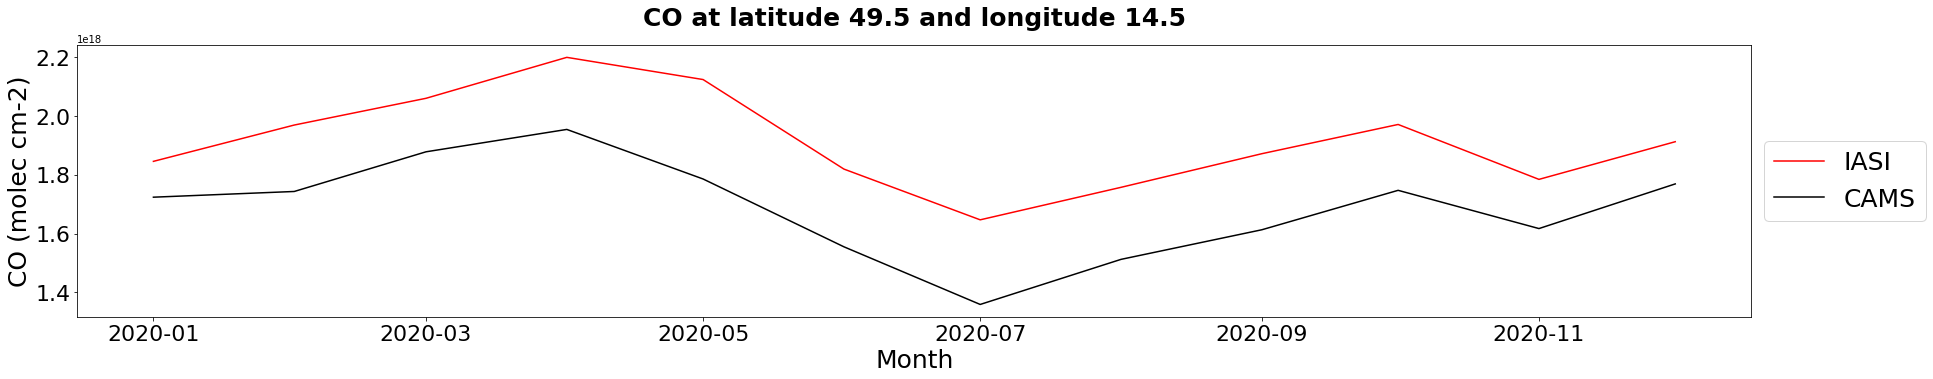

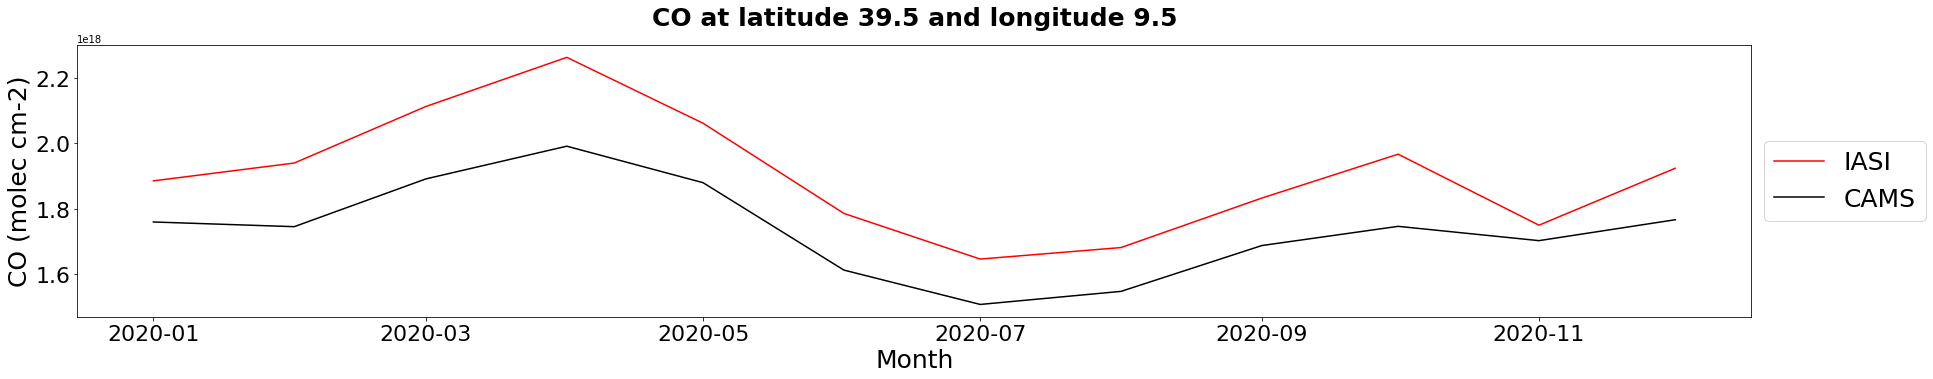

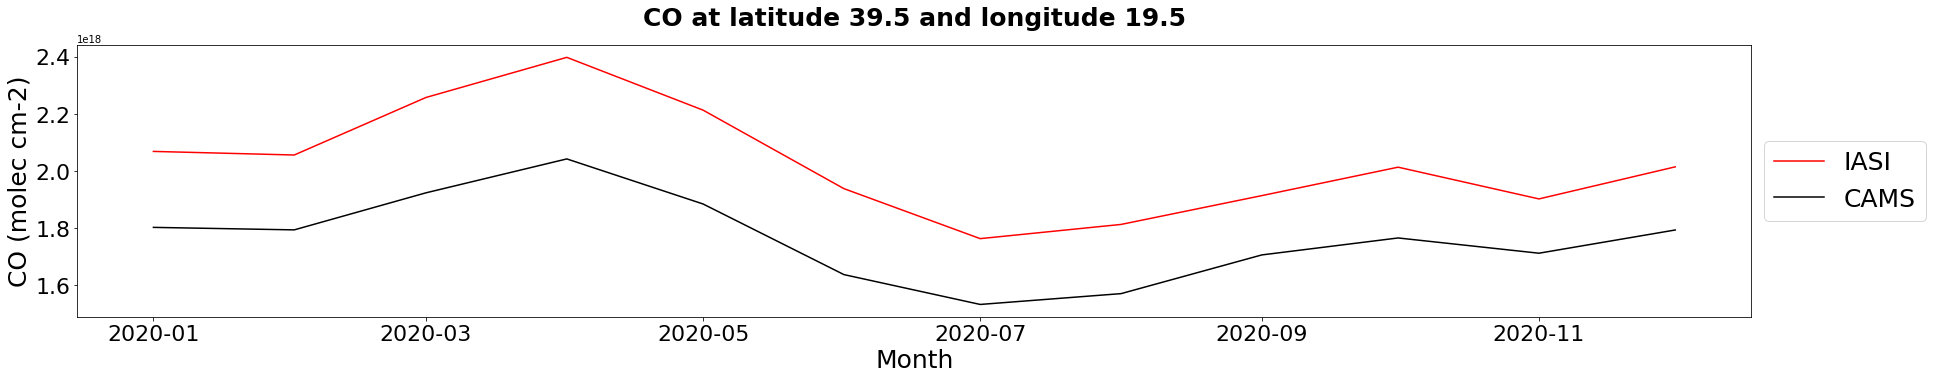

In [18]:
coords_search_list = (50, 15,
                      4, 10,
                      20, 30)
retrieval_table_all =  retrieve_coords(merge_table.dropna(), coords_search_list, component_nom, 
                                       sensor_column, sensor, model, plot_dates, units)
retrieval_table_all

## 8. Scatter plots by bbox

Fit equation: CO_model = CO_sensor * 0.68 + (4.94E+17)
Coefficient of determination (R2): 0.83


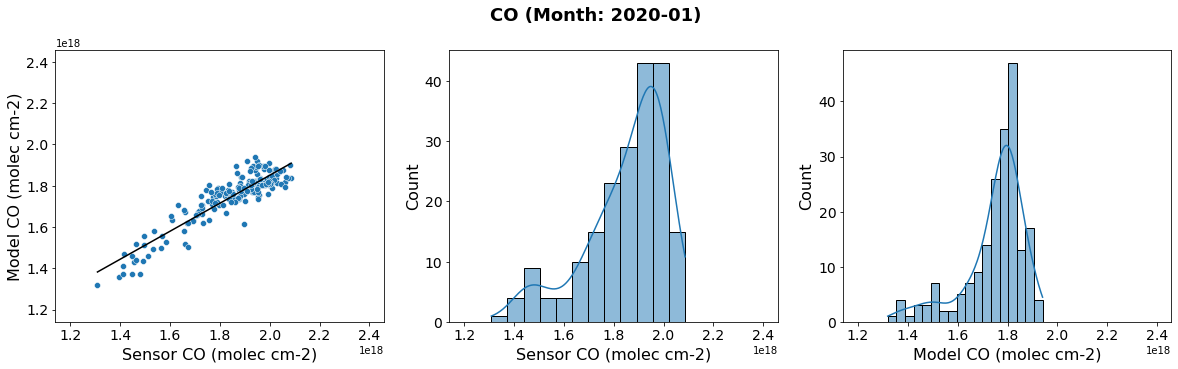

Fit equation: CO_model = CO_sensor * 0.65 + (4.78E+17)
Coefficient of determination (R2): 0.85


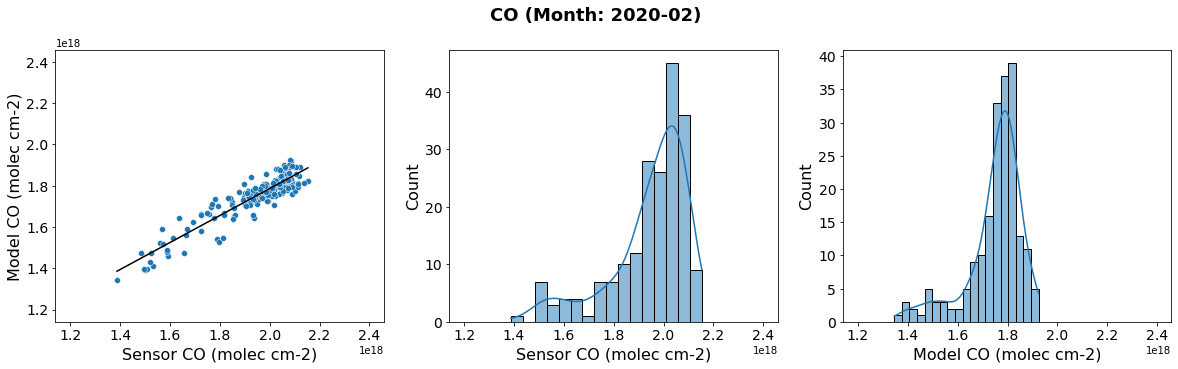

Fit equation: CO_model = CO_sensor * 0.62 + (5.72E+17)
Coefficient of determination (R2): 0.87


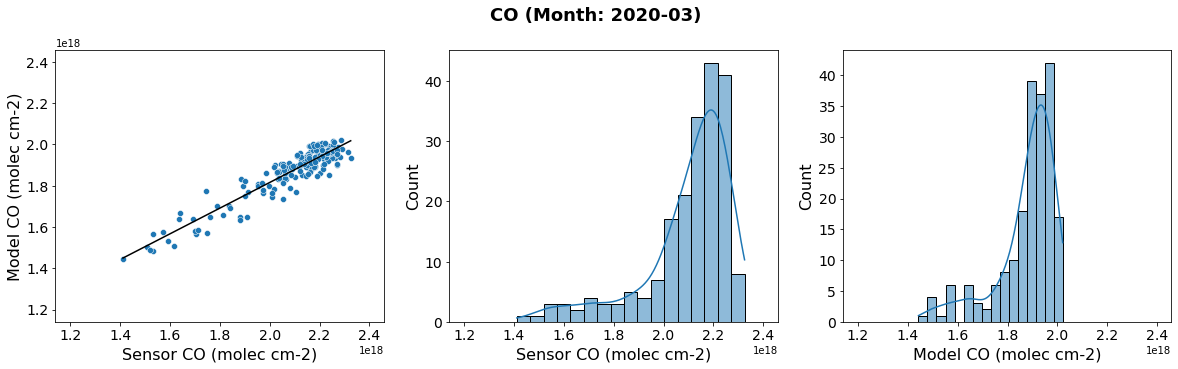

Fit equation: CO_model = CO_sensor * 0.66 + (5.19E+17)
Coefficient of determination (R2): 0.86


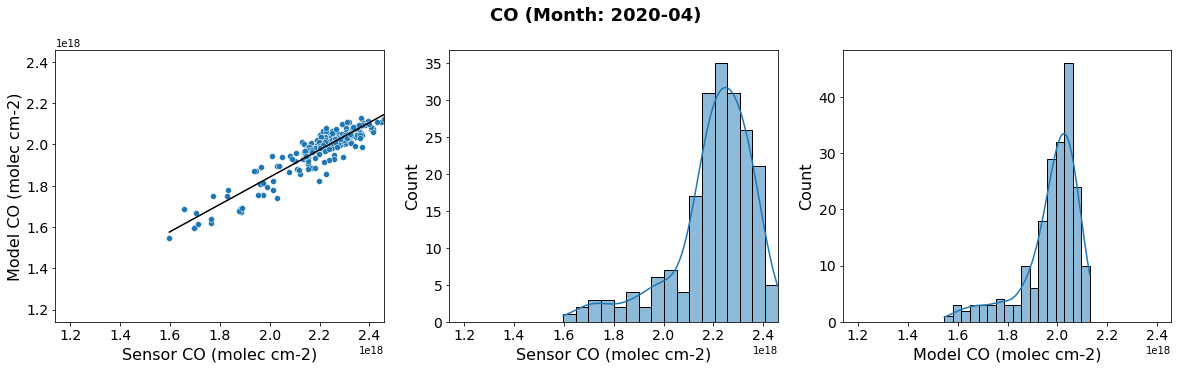

Fit equation: CO_model = CO_sensor * 0.71 + (3.47E+17)
Coefficient of determination (R2): 0.81


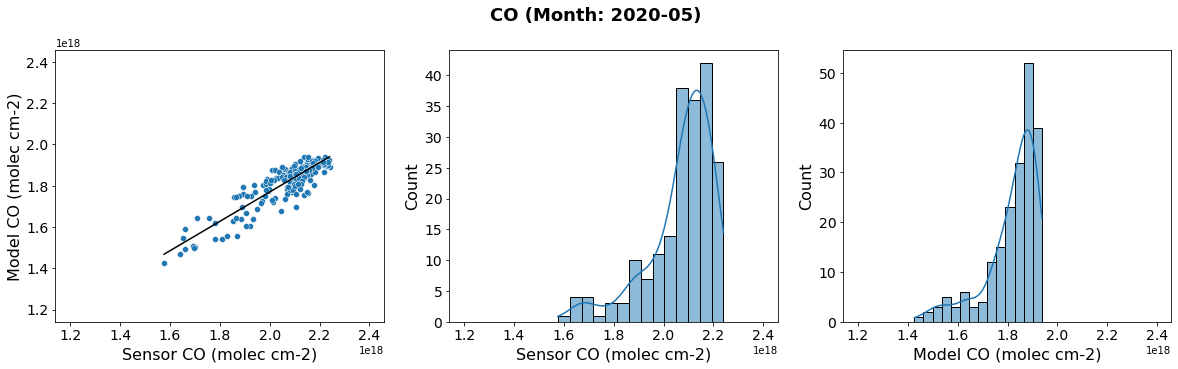

Fit equation: CO_model = CO_sensor * 0.65 + (3.71E+17)
Coefficient of determination (R2): 0.73


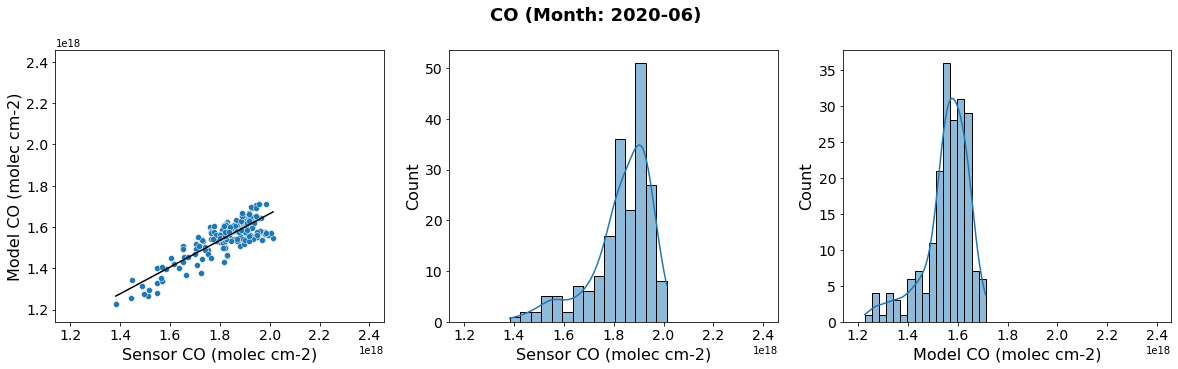

Fit equation: CO_model = CO_sensor * 0.73 + (2.16E+17)
Coefficient of determination (R2): 0.75


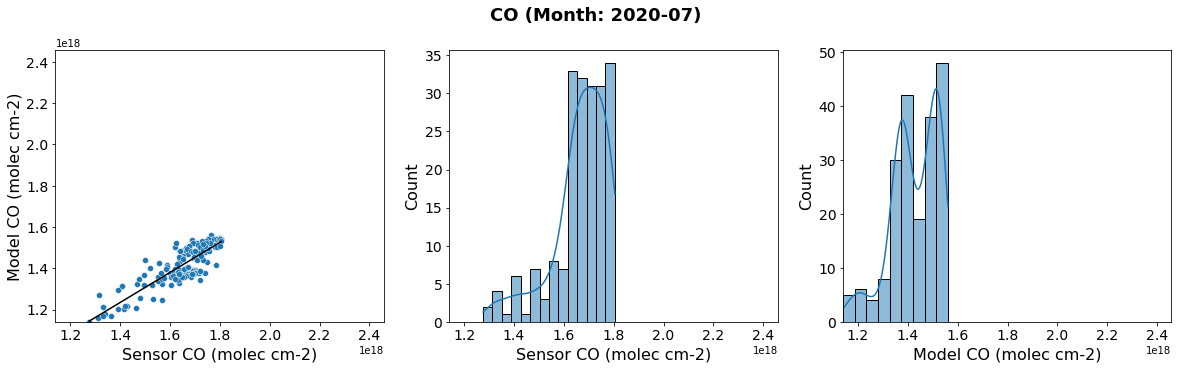

Fit equation: CO_model = CO_sensor * 0.66 + (3.72E+17)
Coefficient of determination (R2): 0.86


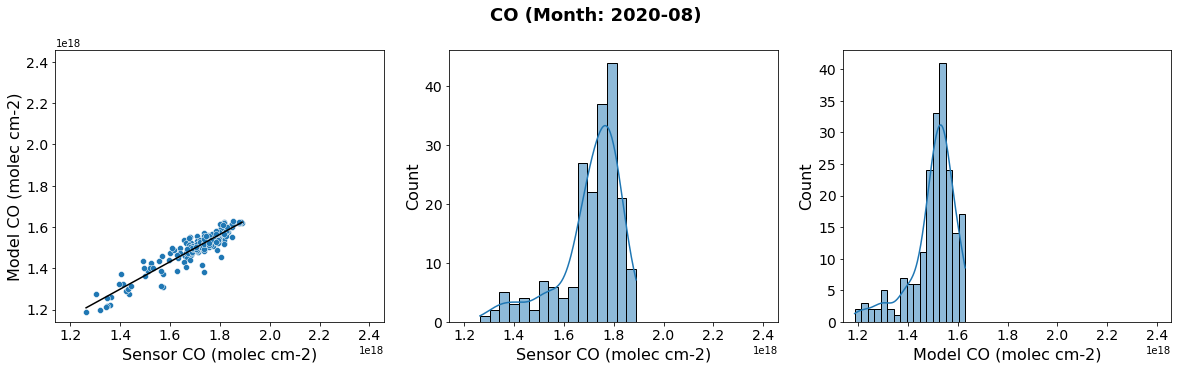

Fit equation: CO_model = CO_sensor * 0.61 + (5.06E+17)
Coefficient of determination (R2): 0.84


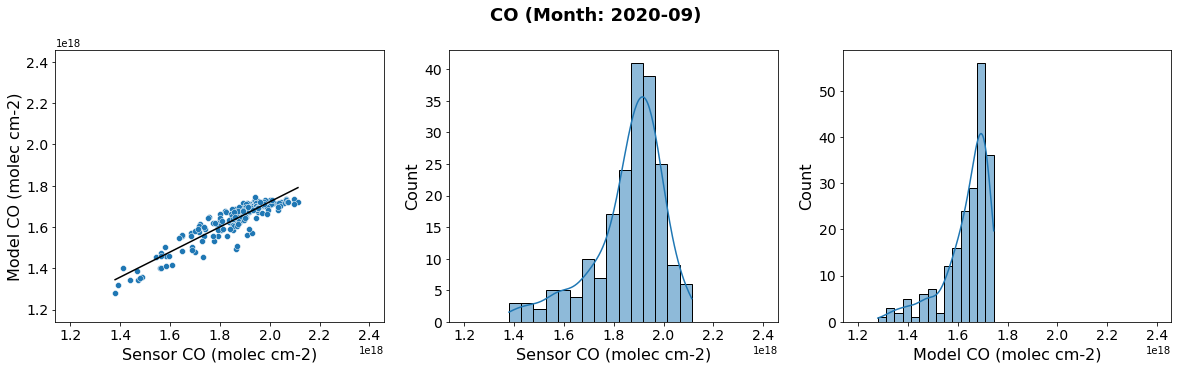

Fit equation: CO_model = CO_sensor * 0.63 + (5.29E+17)
Coefficient of determination (R2): 0.83


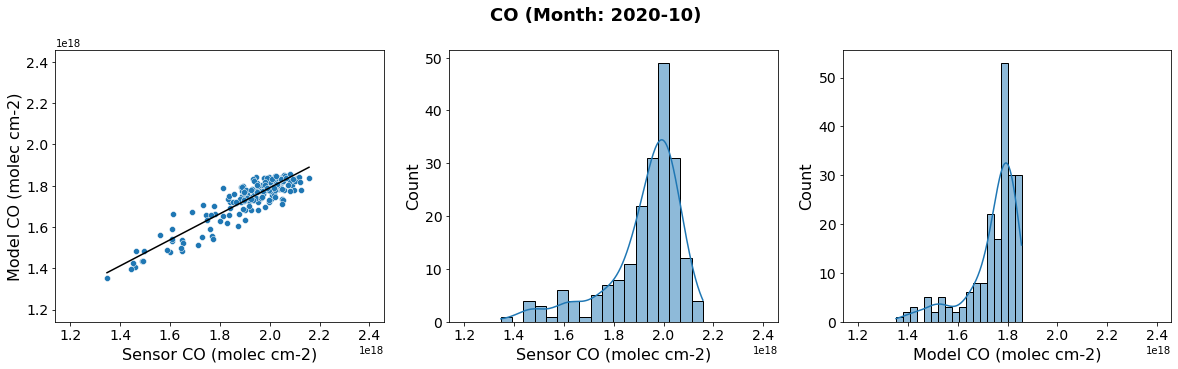

Fit equation: CO_model = CO_sensor * 0.73 + (3.82E+17)
Coefficient of determination (R2): 0.89


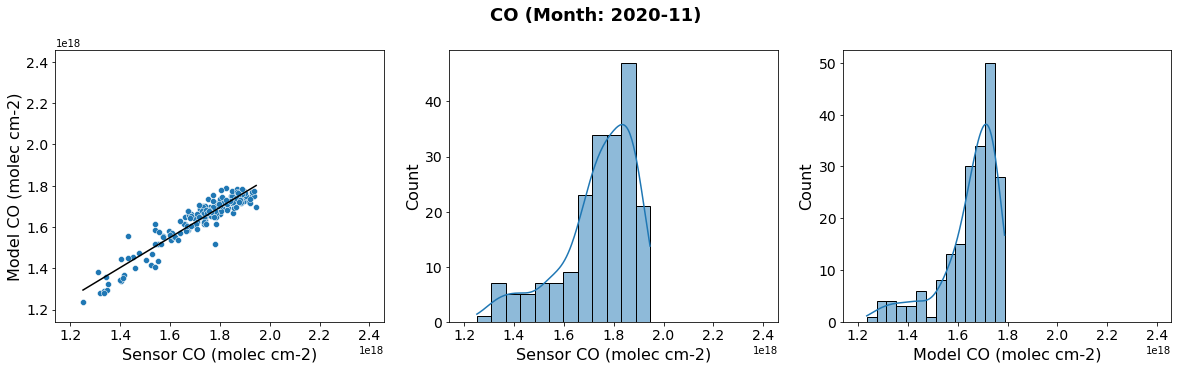

Fit equation: CO_model = CO_sensor * 0.59 + (6.36E+17)
Coefficient of determination (R2): 0.78


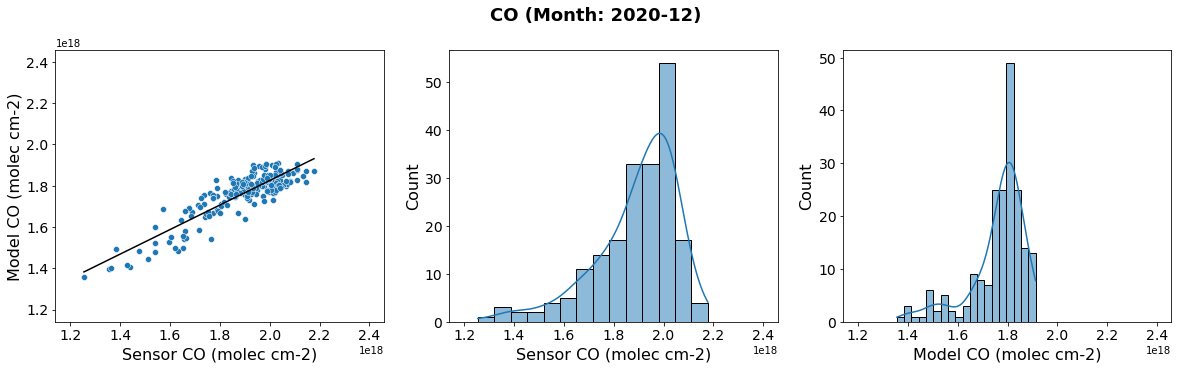

In [19]:
show_seasons = False
extent_definition = 'bbox' # bbox or country
scatter_plot_type = 'individual' # aggregated or individual
summary = scatter_plot(merge_table.dropna(), component_nom, units, sensor_column, sensor, 
                       plot_dates, 1, extent_definition, show_seasons, scatter_plot_type, plot_bbox)

In [20]:
summary

,Period,Location,Score,Coefficient,Intercept
0,2020-01-01,"((0, 40), (20, 50))",0.828196,0.678005,4.944154e+17
1,2020-02-01,"((0, 40), (20, 50))",0.850189,0.653893,4.784957e+17
2,2020-03-01,"((0, 40), (20, 50))",0.868023,0.621878,5.718369e+17
3,2020-04-01,"((0, 40), (20, 50))",0.858047,0.661159,5.191563e+17
4,2020-05-01,"((0, 40), (20, 50))",0.807092,0.711321,3.468593e+17
5,2020-06-01,"((0, 40), (20, 50))",0.728318,0.646525,3.712570e+17
6,2020-07-01,"((0, 40), (20, 50))",0.751203,0.727231,2.159866e+17
7,2020-08-01,"((0, 40), (20, 50))",0.864847,0.662423,3.715067e+17
8,2020-09-01,"((0, 40), (20, 50))",0.843632,0.607844,5.060275e+17
9,2020-10-01,"((0, 40), (20, 50))",0.834963,0.630279,5.293270e+17


## 9. Scatter plots by season

Fit equation: CO_model = CO_sensor * 0.61 + (5.94E+17)
Coefficient of determination (R2): 0.84


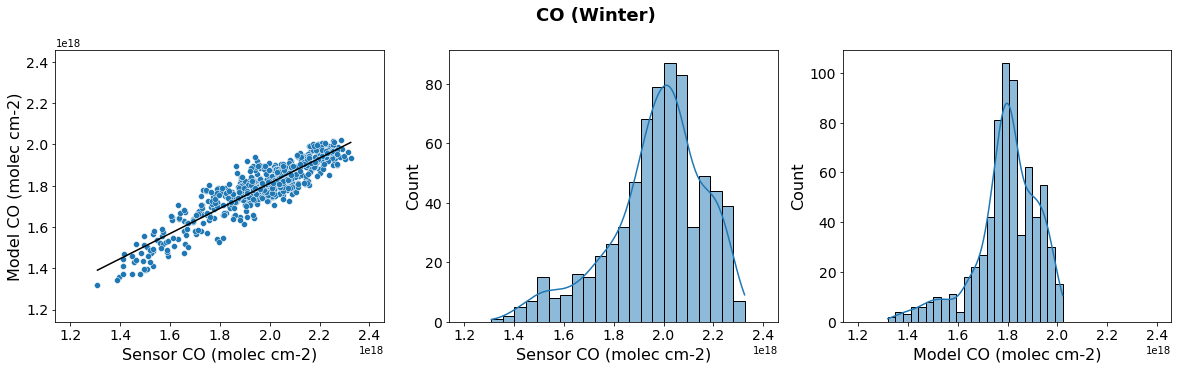

Fit equation: CO_model = CO_sensor * 0.91 + (-7.86E+16)
Coefficient of determination (R2): 0.89


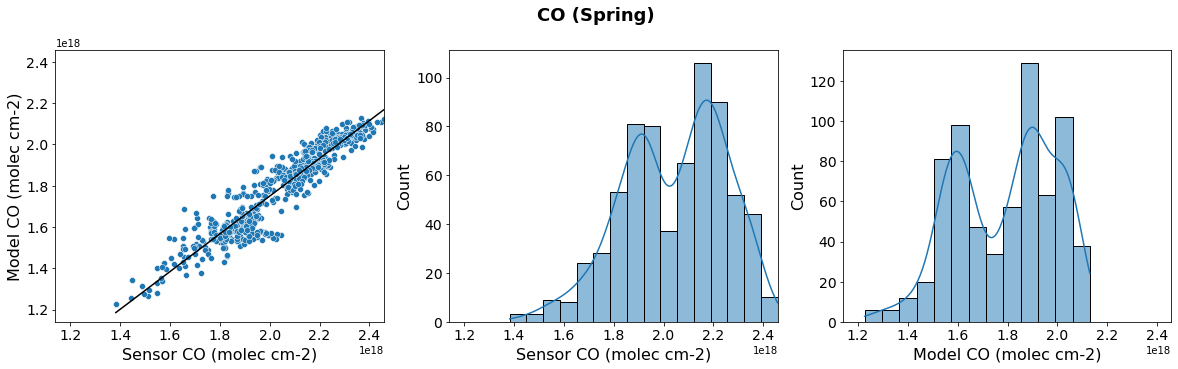

Fit equation: CO_model = CO_sensor * 0.76 + (2.04E+17)
Coefficient of determination (R2): 0.84


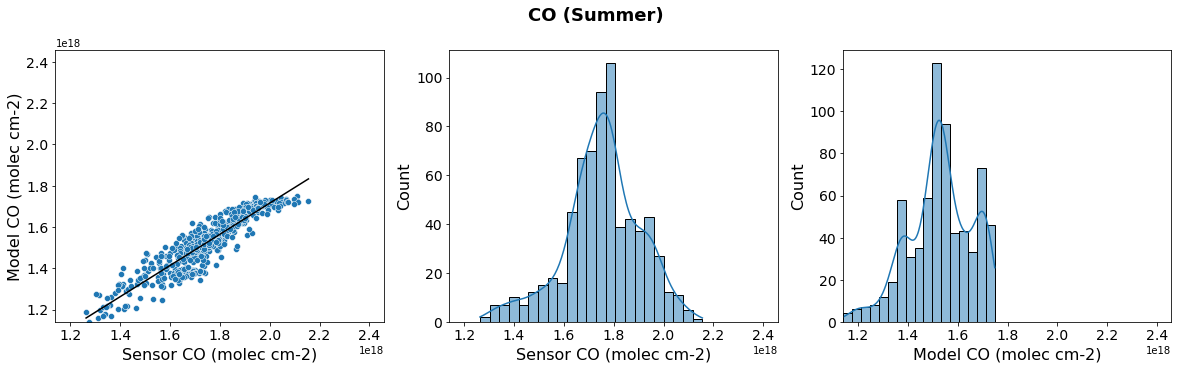

Fit equation: CO_model = CO_sensor * 0.62 + (5.66E+17)
Coefficient of determination (R2): 0.83


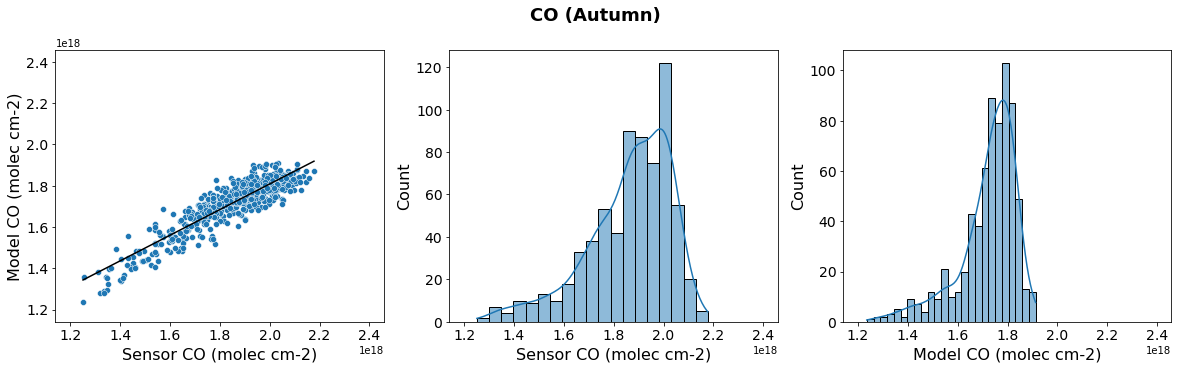

In [21]:
show_seasons = True
extent_definition = 'bbox' # bbox or country
scatter_plot_type = 'individual' # aggregated or individual
summary = scatter_plot(merge_table.dropna(), component_nom, units, sensor_column, sensor, 
                       plot_dates, 1, extent_definition, show_seasons, scatter_plot_type, plot_bbox)

In [22]:
summary

,Period,Location,Score,Coefficient,Intercept
0,Winter,"((0, 40), (20, 50))",0.838741,0.609034,5.935804e+17
1,Spring,"((0, 40), (20, 50))",0.886272,0.914010,-7.855399e+16
2,Summer,"((0, 40), (20, 50))",0.843305,0.755496,2.044767e+17
3,Autumn,"((0, 40), (20, 50))",0.831384,0.620938,5.664903e+17


## 10. Scatter plots by country (Google API required!)

In [23]:
"""
show_seasons = False
extent_definition = 'country' # bbox or country
scatter_plot_type = 'individual' # aggregated or individual
plot_countries = ['France', 'Germany', 'Italy']
summary = scatter_plot(merge_table.dropna(), component_nom, units, sensor_column, sensor, 
                       plot_dates, 1, extent_definition, show_seasons, scatter_plot_type, plot_countries)
"""

"\nshow_seasons = False\nextent_definition = 'country' # bbox or country\nscatter_plot_type = 'individual' # aggregated or individual\nplot_countries = ['France', 'Germany', 'Italy']\nsummary = scatter_plot(merge_table.dropna(), component_nom, units, sensor_column, sensor, \n                       plot_dates, 1, extent_definition, show_seasons, scatter_plot_type, plot_countries)\n"

In [24]:
#summary